In [109]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.pyplot as plt

# Generating ratios from EEG

In [110]:
# Filtering functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if len(data) <= max(len(b), len(a)) * 3:
        return data  # Not enough samples, skip filtering
    return filtfilt(b, a, data)

def apply_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    if len(data) <= max(len(b), len(a)) * 3:
        return data  # Not enough samples, skip filtering
    return filtfilt(b, a, data)

def clean_data(data):
    # Convert to pandas Series to use fill methods
    data = pd.Series(data)

    # Replace inf values with NaN to handle them together
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Forward-fill missing values, and if first value is NaN, fill it with 0 as fallback
    data.ffill(inplace=True)  # Forward-fill NaN values
    data.bfill(inplace=True)  # Backfill in case the first values were NaN

    return data.to_numpy()

# Main analysis function
def compute_ratios(csv_file_path):
    id = os.path.basename(csv_file_path).split('_')[0]
    type = os.path.basename(csv_file_path).split('_')[1:][0]
    type = os.path.splitext(type)[0]
    
    data_df = pd.read_csv(csv_file_path)
    data_df.columns = data_df.columns.str.strip()
    channels_data = data_df[['TP9', 'AF7', 'AF8', 'TP10']]

    sampling_frequency = 256
    fft_size = 256

    # Select middle 10 seconds (if possible)
    ten_sec_samples = sampling_frequency * 10
    if len(channels_data) > ten_sec_samples:
        start_idx = (len(channels_data) - ten_sec_samples) // 2
        channels_data = channels_data.iloc[start_idx:start_idx + ten_sec_samples]

    # Filter each channel
    for column in channels_data.columns:
        channels_data[column] = apply_highpass_filter(channels_data[column], 1, sampling_frequency)

    alpha_powers = []
    beta_powers = []
    theta_powers = []
    gamma_powers = []

    frequency = np.fft.fftfreq(fft_size, 1 / sampling_frequency)
    alpha_band = (frequency >= 8) & (frequency <= 12)
    beta_band = (frequency > 12) & (frequency <= 30)
    theta_band = (frequency >= 4) & (frequency < 8)
    gamma_band = (frequency > 30) & (frequency <= 50)

    for channel in channels_data.columns:
        channel_data = channels_data[channel]
        channel_data = clean_data(channel_data)  # Clean the data to ensure no NaNs or Infs

        # Applying bandpass filters
        filtered_data_theta = apply_bandpass_filter(channel_data, 4, 8, sampling_frequency)
        filtered_data_alpha = apply_bandpass_filter(channel_data, 8, 12, sampling_frequency)
        filtered_data_beta = apply_bandpass_filter(channel_data, 13, 30, sampling_frequency)
        filtered_data_gamma = apply_bandpass_filter(channel_data, 30, 50, sampling_frequency)

        # Perform FFT and calculate power
        spectrum_alpha = np.fft.fft(filtered_data_alpha, fft_size)
        spectrum_beta = np.fft.fft(filtered_data_beta, fft_size)
        spectrum_theta = np.fft.fft(filtered_data_theta, fft_size)
        spectrum_gamma = np.fft.fft(filtered_data_gamma, fft_size)

        power_alpha = np.abs(spectrum_alpha)**2
        power_beta = np.abs(spectrum_beta)**2
        power_theta = np.abs(spectrum_theta)**2
        power_gamma = np.abs(spectrum_gamma)**2

        # Compute the total power
        total_power = np.sum(np.abs(np.fft.fft(channel_data, fft_size))**2)

        # Relative power calculations
        alpha_powers.append(np.sum(power_alpha[alpha_band]) / total_power)
        beta_powers.append(np.sum(power_beta[beta_band]) / total_power)
        theta_powers.append(np.sum(power_theta[theta_band]) / total_power)
        gamma_powers.append(np.sum(power_gamma[gamma_band]) / total_power)    # Frontal Alpha Asymmetry

    # Calculate Frontal Alpha Asymmetry using AF7 and AF8 channels
    af7_data = channels_data['AF7']
    af8_data = channels_data['AF8']
    af7_data = clean_data(channels_data['AF7'].to_numpy())
    af8_data = clean_data(channels_data['AF8'].to_numpy())
    fft_af7 = fft(af7_data, fft_size)
    fft_af8 = fft(af8_data, fft_size)
    total_power_af7 = np.sum(np.abs(fft_af7)**2)
    total_power_af8 = np.sum(np.abs(fft_af8)**2)

    theta_beta_ratio = np.mean(theta_powers) / np.mean(beta_powers)
    alpha_beta_ratio = np.mean(alpha_powers) / np.mean(beta_powers)
    beta_theta_ratio = np.mean(beta_powers) / np.mean(theta_powers)
    beta_alpha_ratio = np.mean(beta_powers) / np.mean(alpha_powers)
    gamma_beta_ratio = np.mean(gamma_powers) / np.mean(beta_powers)
    frontal_alpha_asymmetry = np.log(total_power_af7 + 1e-8) - np.log(total_power_af8 + 1e-8)

    return {
        "id": id,
        f"Theta/Beta Ratio {type}": theta_beta_ratio,
        f"Alpha/Beta Ratio {type}": alpha_beta_ratio,
        f"Beta/Theta Ratio {type}": beta_theta_ratio,
        f"Beta/Alpha Ratio {type}": beta_alpha_ratio,
        f"Gamma/Beta Ratio {type}": gamma_beta_ratio,
        f"Frontal Alpha Asymmetry {type}": frontal_alpha_asymmetry,
    }


In [111]:
files = glob.glob("Data/EEG/*.csv")
results = []
columns = []
for file in files:
    ratios = compute_ratios(file)
    results.append(ratios)
    columns.extend(ratios.keys())
columns = list(set(columns))

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_6192\1927844652.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_data[column] = apply_highpass_filter(channels_data[column], 1, sampling_frequency)


In [112]:
# columns
results_df = pd.DataFrame(results, columns=columns)
results_df = results_df.set_index('id')

In [113]:
results_df.groupby('id').sum().replace(0, np.nan).to_csv(os.path.abspath('./results/ratios.csv'))

# Analsysing EEGs through Plots and tables

In [114]:
ratios_data = pd.read_csv(os.path.abspath('./results/ratios.csv'))

In [115]:
groups=pd.read_csv(os.path.abspath('./Group.csv'),header=0)

In [116]:
ratio_copy=pd.merge(ratios_data, groups, on='id', how='left')

In [117]:
# ratio_copy = ratios_data.copy()
# ratio_copy.drop(columns= ["id"])
# Exclude non-numeric columns before applying mean
numeric_columns = ratio_copy.select_dtypes(include=[np.number])
ratios_grouped = numeric_columns.groupby(ratio_copy['Group']).mean()
ratios_grouped.columns

Index(['id', 'Theta/Beta Ratio post', 'Gamma/Beta Ratio post',
       'Theta/Beta Ratio dur', 'Beta/Theta Ratio post',
       'Beta/Alpha Ratio post', 'Beta/Alpha Ratio dur',
       'Alpha/Beta Ratio post', 'Beta/Alpha Ratio pre',
       'Frontal Alpha Asymmetry post', 'Frontal Alpha Asymmetry pre',
       'Gamma/Beta Ratio pre', 'Alpha/Beta Ratio dur', 'Gamma/Beta Ratio dur',
       'Beta/Theta Ratio pre', 'Beta/Theta Ratio dur', 'Theta/Beta Ratio pre',
       'Frontal Alpha Asymmetry dur', 'Alpha/Beta Ratio pre', 'Group'],
      dtype='object')

### Alpha/Beta Ratio (ABR) Relaxation

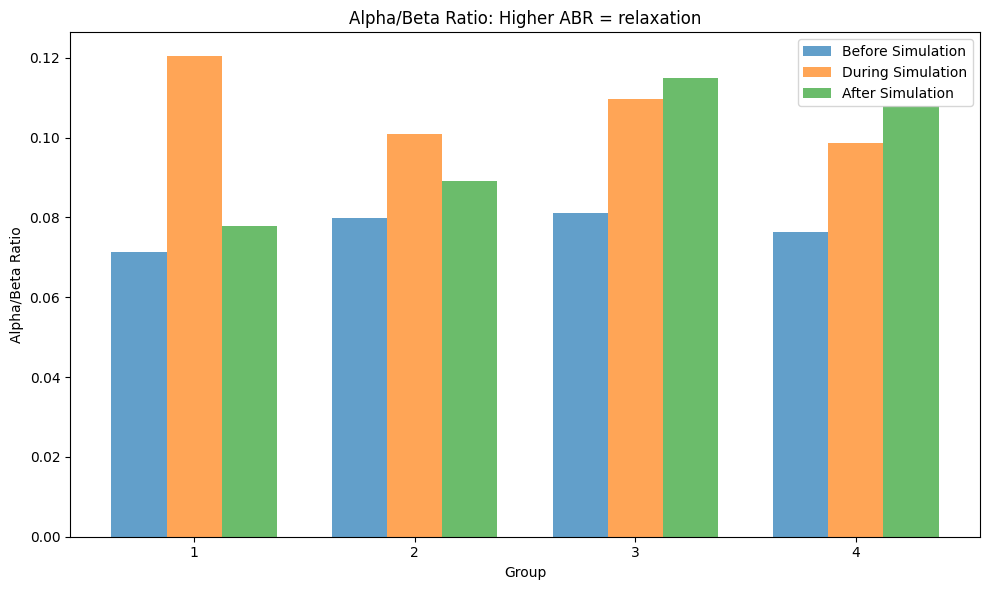

In [118]:
# plt.bar(["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"], ratios_grouped[["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"]])
# Plot Alpha/Beta Ratio for dur, pre and post in a side-by-side bar graph
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Alpha/Beta Ratio pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Alpha/Beta Ratio dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Alpha/Beta Ratio post"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Alpha/Beta Ratio")
plt.title("Alpha/Beta Ratio: Higher ABR = relaxation")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

### Theta/Beta Ratio (TBR) Stress level

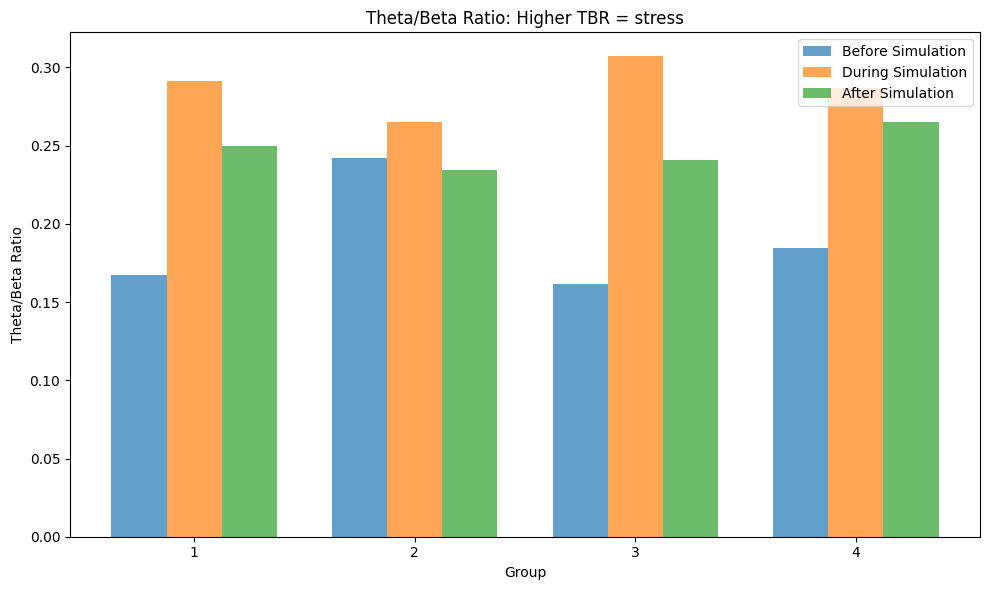

In [119]:
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Theta/Beta Ratio pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Theta/Beta Ratio dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Theta/Beta Ratio post"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Theta/Beta Ratio")
plt.title("Theta/Beta Ratio: Higher TBR = stress")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

### Gamma/Beta Ratio (GBR) high performance and cognition

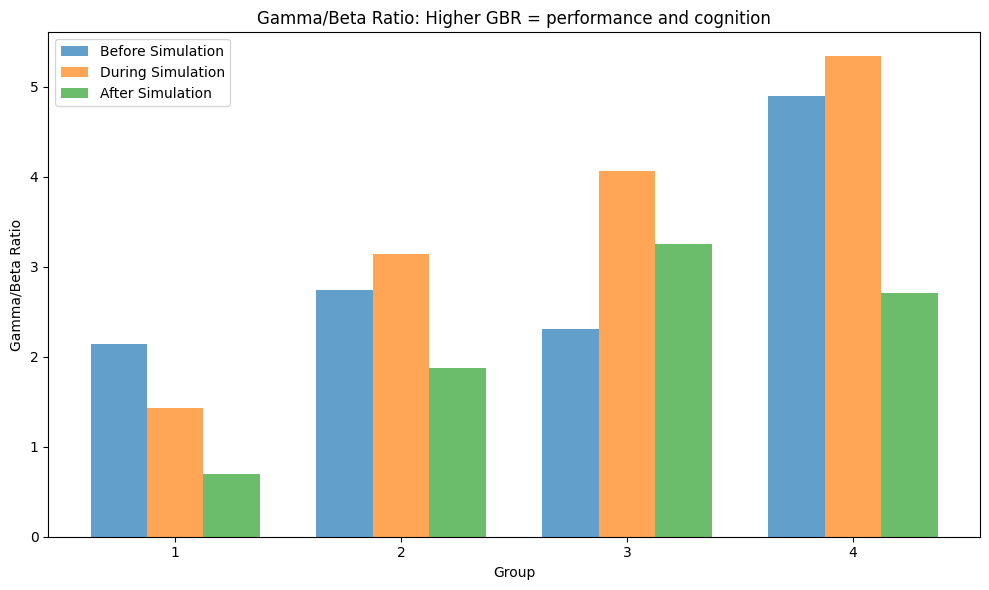

In [120]:
# Plot Gamma/Beta Ratio for dur, pre and post in a side-by-side bar graph
plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Gamma/Beta Ratio pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Gamma/Beta Ratio dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Gamma/Beta Ratio post"], width, label="After Simulation", alpha=0.7)
plt.xlabel("Group")
plt.ylabel("Gamma/Beta Ratio")
plt.title("Gamma/Beta Ratio: Higher GBR = performance and cognition")
plt.xticks(x, ratios_grouped.index)
plt.legend()
plt.tight_layout()
plt.show()


### Frontal Alpha Asymmetry (FAA) positive or negative emotion

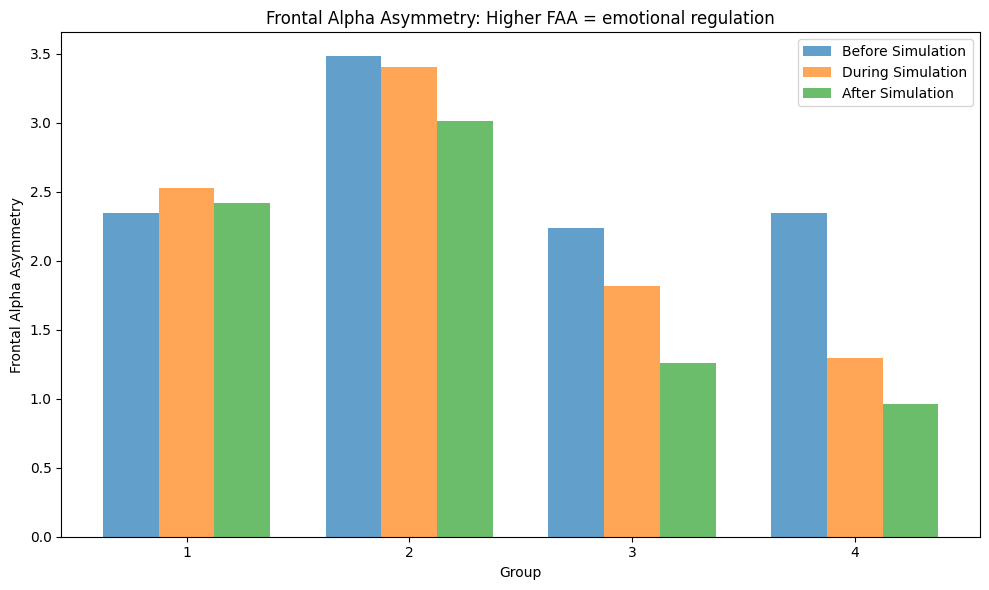

In [121]:
# Plot Frontal Alpha Asymmetry for dur, pre and post in a side-by-side bar graph
plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Frontal Alpha Asymmetry pre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Frontal Alpha Asymmetry dur"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Frontal Alpha Asymmetry post"], width, label="After Simulation", alpha=0.7)
plt.xlabel("Group")
plt.ylabel("Frontal Alpha Asymmetry")
plt.title("Frontal Alpha Asymmetry: Higher FAA = emotional regulation")
plt.xticks(x, ratios_grouped.index)
plt.legend()
plt.tight_layout()
plt.show()


In [122]:
files = glob.glob("Data/EEG/dur/*.csv")
results = []
columns = []
for file in files:
    ratios = compute_ratios(file)
    results.append(ratios)
    columns.extend(ratios.keys())
columns = list(set(columns))

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_6192\1927844652.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_data[column] = apply_highpass_filter(channels_data[column], 1, sampling_frequency)
C:\Users\Rishabh\AppData\Local\Temp\ipykernel_6192\1927844652.py:99: RuntimeWarning: invalid value encountered in scalar divide
  alpha_powers.append(np.sum(power_alpha[alpha_band]) / total_power)
C:\Users\Rishabh\AppData\Local\Temp\ipykernel_6192\1927844652.py:100: RuntimeWarning: invalid value encountered in scalar divide
  beta_powers.append(np.sum(power_beta[beta_band]) / total_power)
C:\Users\Rishabh\AppData\Local\Temp\ipykernel_6192\1927844652.py:101: RuntimeWarning: invalid value encountered in scalar divide
  theta_powers.append(np.sum

In [123]:
# columns
results_df = pd.DataFrame(results, columns=columns)
results_df = results_df.set_index('id')

In [124]:
results_df.groupby('id').sum().replace(0, np.nan).to_csv(os.path.abspath('./results/ratios_dur.csv'))

# Analsysing EEGs through Plots and tables

In [125]:
ratios_data = pd.read_csv(os.path.abspath('./results/ratios_dur.csv'))

In [126]:
groups=pd.read_csv(os.path.abspath('./Group.csv'),header=0)

In [127]:
ratio_copy=pd.merge(ratios_data, groups, on='id', how='left')

In [128]:
# ratio_copy = ratios_data.copy()
# ratio_copy.drop(columns= ["id"])
# Exclude non-numeric columns before applying mean
numeric_columns = ratio_copy.select_dtypes(include=[np.number])
ratios_grouped = numeric_columns.groupby(ratio_copy['Group']).mean()
ratios_grouped.columns

Index(['id', 'Gamma/Beta Ratio durPost', 'Beta/Alpha Ratio durEarthquake',
       'Beta/Theta Ratio durEarthquake', 'Theta/Beta Ratio durEarthquake',
       'Frontal Alpha Asymmetry durEarthquake',
       'Frontal Alpha Asymmetry durPre', 'Alpha/Beta Ratio durPost',
       'Theta/Beta Ratio durPost', 'Beta/Theta Ratio durPre',
       'Alpha/Beta Ratio durPre', 'Beta/Theta Ratio durPost',
       'Gamma/Beta Ratio durEarthquake', 'Beta/Alpha Ratio durPost',
       'Frontal Alpha Asymmetry durPost', 'Theta/Beta Ratio durPre',
       'Gamma/Beta Ratio durPre', 'Alpha/Beta Ratio durEarthquake',
       'Beta/Alpha Ratio durPre', 'Group'],
      dtype='object')

### Alpha/Beta Ratio (ABR) Relaxation

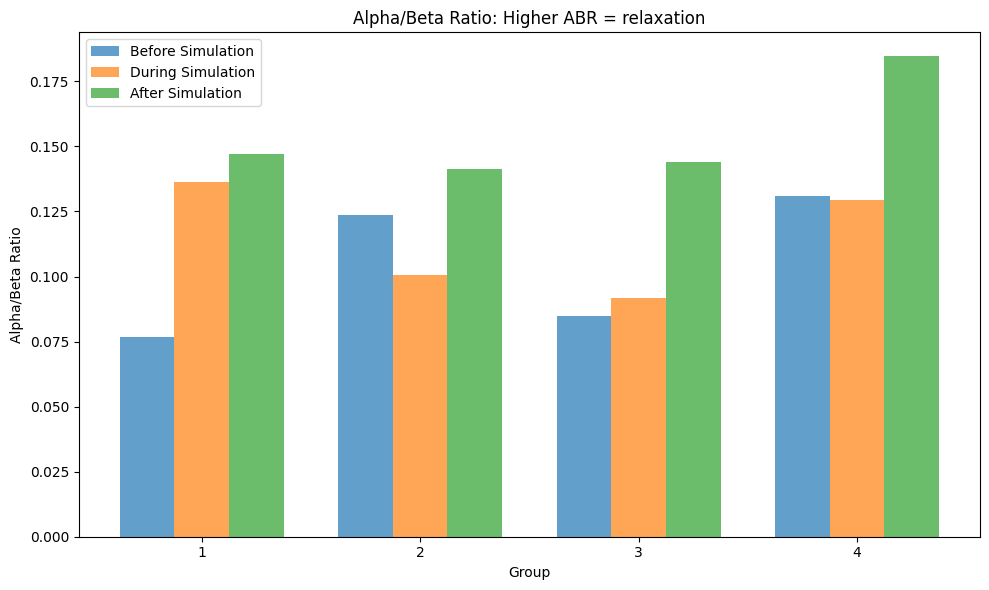

In [129]:
# plt.bar(["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"], ratios_grouped[["Alpha/Beta Ratio dur", "Alpha/Beta Ratio pre", "Alpha/Beta Ratio post"]])
# Plot Alpha/Beta Ratio for dur, pre and post in a side-by-side bar graph
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Alpha/Beta Ratio durPre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Alpha/Beta Ratio durEarthquake"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Alpha/Beta Ratio durPost"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Alpha/Beta Ratio")
plt.title("Alpha/Beta Ratio: Higher ABR = relaxation")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

### Theta/Beta Ratio (TBR) Stress level

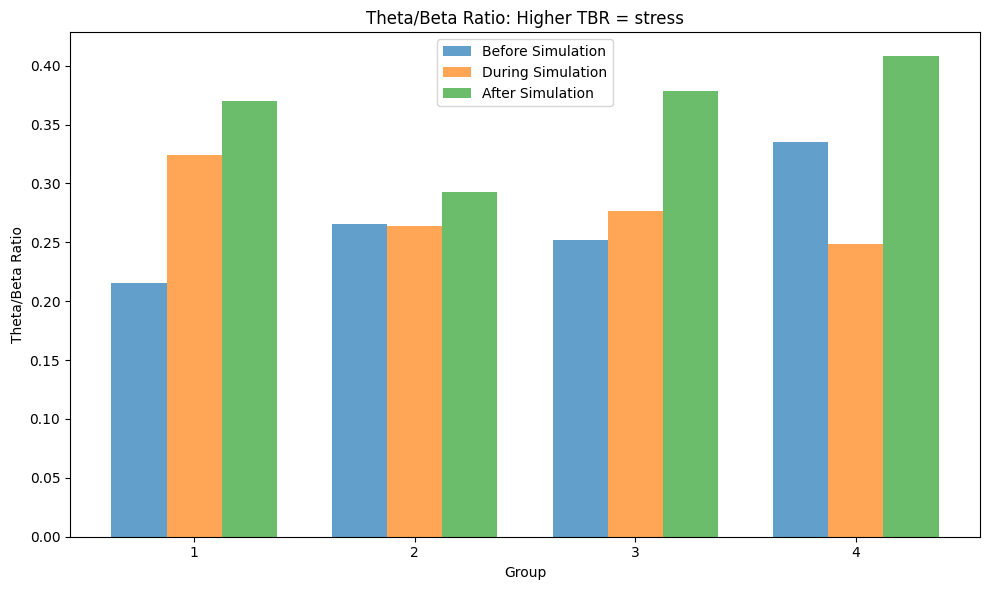

In [130]:
x = np.arange(len(ratios_grouped.index))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Theta/Beta Ratio durPre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Theta/Beta Ratio durEarthquake"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Theta/Beta Ratio durPost"], width, label="After Simulation", alpha=0.7)

plt.xlabel("Group")
plt.ylabel("Theta/Beta Ratio")
plt.title("Theta/Beta Ratio: Higher TBR = stress")
plt.xticks(x, ratios_grouped.index)

plt.legend()
plt.tight_layout()
plt.show()

### Gamma/Beta Ratio (GBR) high performance and cognition

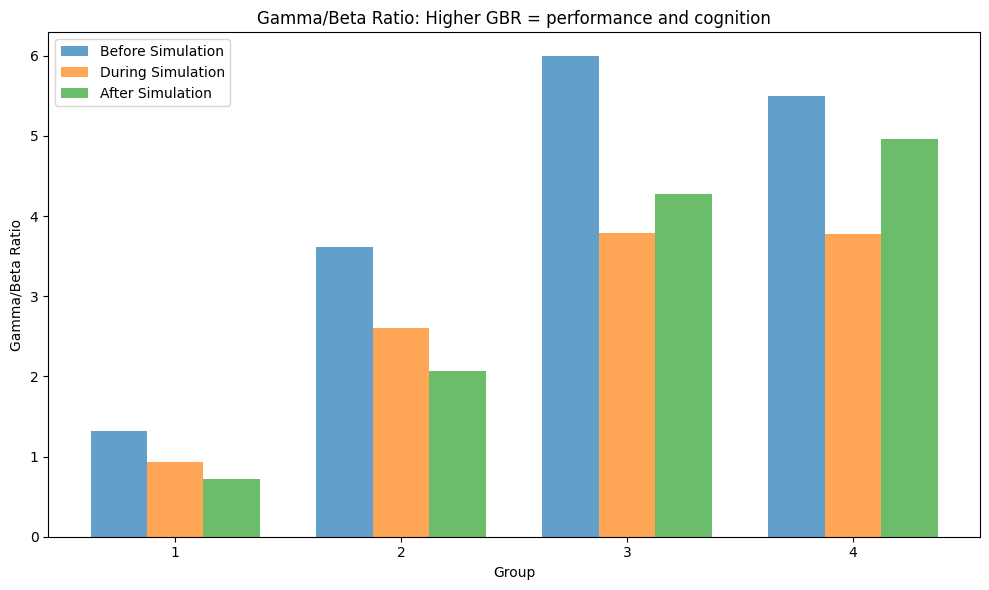

In [131]:
# Plot Gamma/Beta Ratio for dur, pre and post in a side-by-side bar graph
plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Gamma/Beta Ratio durPre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Gamma/Beta Ratio durEarthquake"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Gamma/Beta Ratio durPost"], width, label="After Simulation", alpha=0.7)
plt.xlabel("Group")
plt.ylabel("Gamma/Beta Ratio")
plt.title("Gamma/Beta Ratio: Higher GBR = performance and cognition")
plt.xticks(x, ratios_grouped.index)
plt.legend()
plt.tight_layout()
plt.show()


### Frontal Alpha Asymmetry (FAA) positive or negative emotion

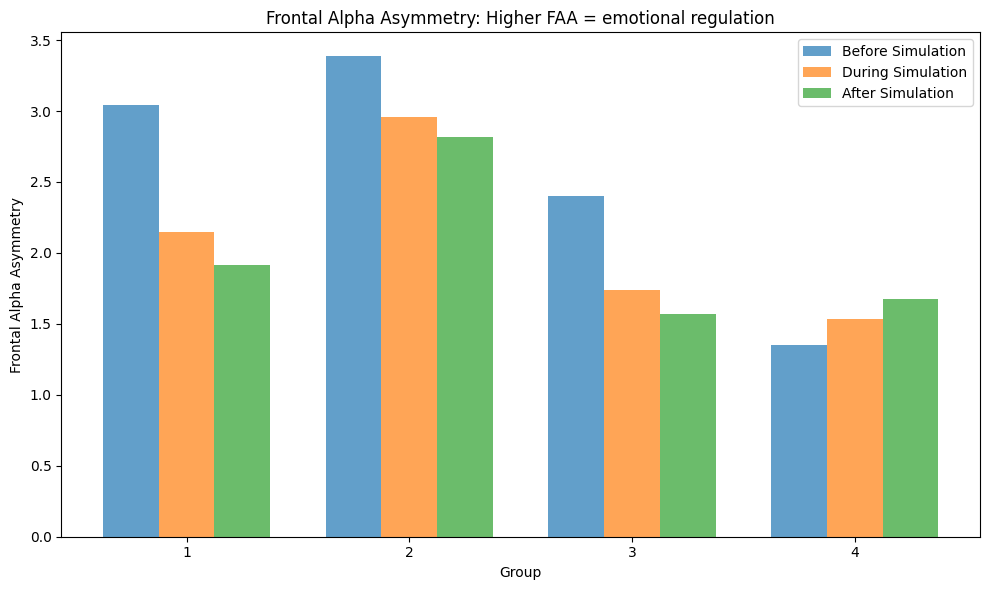

In [132]:
# Plot Frontal Alpha Asymmetry for dur, pre and post in a side-by-side bar graph
plt.figure(figsize=(10, 6))
plt.bar(x -width, ratios_grouped["Frontal Alpha Asymmetry durPre"], width, label="Before Simulation", alpha=0.7)
plt.bar(x , ratios_grouped["Frontal Alpha Asymmetry durEarthquake"], width, label="During Simulation", alpha=0.7)
plt.bar(x + width, ratios_grouped["Frontal Alpha Asymmetry durPost"], width, label="After Simulation", alpha=0.7)
plt.xlabel("Group")
plt.ylabel("Frontal Alpha Asymmetry")
plt.title("Frontal Alpha Asymmetry: Higher FAA = emotional regulation")
plt.xticks(x, ratios_grouped.index)
plt.legend()
plt.tight_layout()
plt.show()
